In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!nvidia-smi

Mon May 27 13:52:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Directories
data_dir = '/content/drive/MyDrive/Colab/112-2-DLA/final/data'
data_dir

'/content/drive/MyDrive/Colab/112-2-DLA/final/data'

In [6]:
config = {
    'train_ratio': 0.8,
    'valid_ratio': 0.1,
    'test_ratio': 0.1,
    'batch_size': 64,
    'num_epochs': 30,
}

In [7]:
# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)
full_dataset

Dataset ImageFolder
    Number of datapoints: 5250
    Root location: /content/drive/MyDrive/Colab/112-2-DLA/final/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from torch.utils.data import DataLoader, Subset

# Assuming full_dataset is a torchvision dataset or similar
targets = np.array(full_dataset.targets)  # Extract the target labels

# Define the split ratios
train_ratio, val_ratio = config['train_ratio'], config['valid_ratio']
test_ratio = 1 - train_ratio - val_ratio

# First stratified split to get training set and temporary set (validation + test)
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=42)
train_idx, temp_idx = next(sss_train.split(np.zeros(len(targets)), targets))

# Extract the targets for the temporary set
temp_targets = targets[temp_idx]

# Second stratified split to split the temporary set into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio/(val_ratio + test_ratio), random_state=620)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_targets)), temp_targets))

# Map the indices back to the original dataset
val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]

# Create the Subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

# Dataloaders and dataset sizes
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Class names
class_names = full_dataset.classes
class_names

['battery',
 'glass',
 'metal',
 'normal plastic',
 'paper',
 'paper container',
 'plastic bottle']

In [9]:
# Model
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


In [10]:
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = model.state_dict()
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())  # Ensure it's on CPU and convert to item
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print(f'Best val Acc: {best_val_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Train model
model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=config['num_epochs'])


Epoch 0/29


train Loss: 1.7055 Acc: 0.4812


val Loss: 1.3603 Acc: 0.7200
Epoch 1/29


train Loss: 1.0986 Acc: 0.7450


val Loss: 0.8647 Acc: 0.8038
Epoch 2/29


train Loss: 0.7353 Acc: 0.8021


val Loss: 0.5822 Acc: 0.8514
Epoch 3/29


train Loss: 0.5675 Acc: 0.8383


val Loss: 0.5153 Acc: 0.8571
Epoch 4/29


train Loss: 0.4742 Acc: 0.8576


val Loss: 0.4337 Acc: 0.8743
Epoch 5/29


train Loss: 0.4142 Acc: 0.8800


val Loss: 0.3893 Acc: 0.8762
Epoch 6/29


train Loss: 0.3687 Acc: 0.8769


val Loss: 0.3576 Acc: 0.9010
Epoch 7/29


train Loss: 0.3123 Acc: 0.9026


val Loss: 0.3389 Acc: 0.8724
Epoch 8/29


train Loss: 0.3103 Acc: 0.8974


val Loss: 0.3372 Acc: 0.8838
Epoch 9/29


train Loss: 0.2780 Acc: 0.9138


val Loss: 0.2934 Acc: 0.9086
Epoch 10/29


train Loss: 0.2558 Acc: 0.9219


val Loss: 0.2683 Acc: 0.9162
Epoch 11/29


train Loss: 0.2382 Acc: 0.9286


val Loss: 0.2333 Acc: 0.9295
Epoch 12/29


train Loss: 0.2337 Acc: 0.9255


val Loss: 0.2312 Acc: 0.9124
Epoch 13/29


train Loss: 0.2109 Acc: 0.9300


val Loss: 0.2301 Acc: 0.9181
Epoch 14/29


train Loss: 0.2060 Acc: 0.9352


val Loss: 0.2712 Acc: 0.9105
Epoch 15/29


train Loss: 0.2051 Acc: 0.9321


val Loss: 0.2247 Acc: 0.9257
Epoch 16/29


train Loss: 0.1879 Acc: 0.9402


val Loss: 0.2165 Acc: 0.9219
Epoch 17/29


train Loss: 0.1740 Acc: 0.9457


val Loss: 0.2124 Acc: 0.9276
Epoch 18/29


train Loss: 0.1681 Acc: 0.9467


val Loss: 0.1988 Acc: 0.9276
Epoch 19/29


train Loss: 0.1600 Acc: 0.9526


val Loss: 0.2011 Acc: 0.9295
Epoch 20/29


train Loss: 0.1628 Acc: 0.9488


val Loss: 0.2338 Acc: 0.9371
Epoch 21/29


train Loss: 0.1520 Acc: 0.9512


val Loss: 0.1882 Acc: 0.9276
Epoch 22/29


train Loss: 0.1407 Acc: 0.9557


val Loss: 0.2148 Acc: 0.9314
Epoch 23/29


train Loss: 0.1300 Acc: 0.9617


val Loss: 0.1986 Acc: 0.9371
Epoch 24/29


train Loss: 0.1349 Acc: 0.9562


val Loss: 0.1989 Acc: 0.9257
Epoch 25/29


train Loss: 0.1465 Acc: 0.9510


val Loss: 0.1703 Acc: 0.9448
Epoch 26/29


train Loss: 0.1174 Acc: 0.9624


val Loss: 0.1858 Acc: 0.9524
Epoch 27/29


train Loss: 0.1336 Acc: 0.9576


val Loss: 0.1282 Acc: 0.9524
Epoch 28/29


train Loss: 0.1231 Acc: 0.9610


val Loss: 0.1673 Acc: 0.9371
Epoch 29/29


train Loss: 0.1135 Acc: 0.9657


val Loss: 0.1819 Acc: 0.9429
Best val Acc: 0.9524


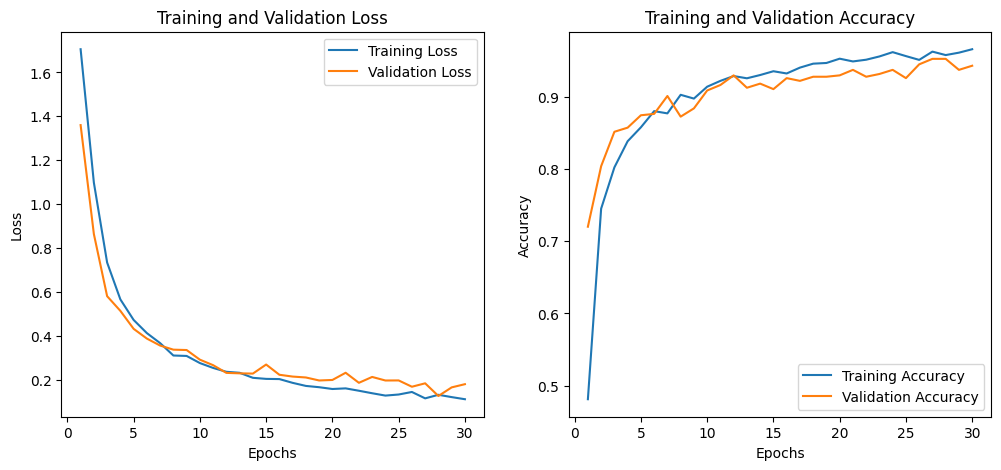

In [11]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Test Loss: 0.1969 Acc: 0.9467


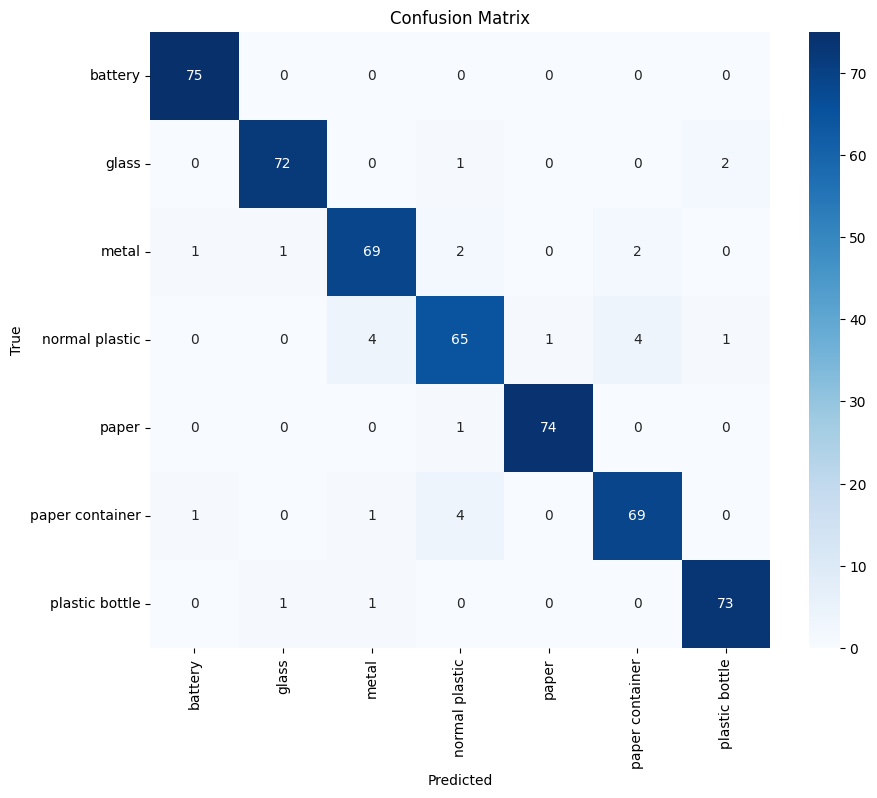


Classification Report:
                 precision    recall  f1-score   support

        battery       0.97      1.00      0.99        75
          glass       0.97      0.96      0.97        75
          metal       0.92      0.92      0.92        75
 normal plastic       0.89      0.87      0.88        75
          paper       0.99      0.99      0.99        75
paper container       0.92      0.92      0.92        75
 plastic bottle       0.96      0.97      0.97        75

       accuracy                           0.95       525
      macro avg       0.95      0.95      0.95       525
   weighted avg       0.95      0.95      0.95       525

Weighted F1 Score: 0.9465
Macro-average F1 Score: 0.9465
Micro-average F1 Score: 0.9467


In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Evaluate model on the test set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    loss = running_loss / len(dataloader.dataset)
    acc = running_corrects.double() / len(dataloader.dataset)

    print(f'Test Loss: {loss:.4f} Acc: {acc:.4f}')

    return all_labels, all_preds

# Evaluate on the test set
all_labels, all_preds = evaluate_model(model, dataloaders['test'])

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print('\nClassification Report:')
print(class_report)

# F1 Score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')

# Macro- and Micro-average F1 Scores
macro_f1 = f1_score(all_labels, all_preds, average='macro')
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Macro-average F1 Score: {macro_f1:.4f}')
print(f'Micro-average F1 Score: {micro_f1:.4f}')

In [ ]:
# Save model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab/112-2-DLA/final/resnet50.ckpt')